<a href="https://colab.research.google.com/github/yxuan0616/simpleproject/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training a wave breaker type classifier.
input 12 numbers, breaking point and shoreline of three strips. This needs to be changed because Ho and Lo were not put in, so the input data does not include the offshore wave data yet.

output: 4 numbers,  probability of 'negative slope',  'Sp', 'Pl', 'Sur'.

#Make sure the data file is uploaded here everytime running this notebook.

In [0]:
import pickle as pk
import numpy as np

from matplotlib import ticker, cm
import matplotlib.pyplot as plt
from matplotlib import colors

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import time

import os
import matplotlib.font_manager
plt.rcParams["font.family"] = "Times New Roman"


#testing on 2 days

In [0]:
file = "partial"
with open(file, "rb") as f:
    x,poplist,Hos,Los,newIs,Xb,Xs,Xname = pk.load(f)
# for index in sorted(poplist, reverse=True):
# #    del I[index]
#     del Los[index]
#     del Hos[index]
#     del Y[index]
#     del Lab[index]
#     del newIs[index]
#     del Xname[index]
Is = []
Ls = []
for i in range(len(newIs)):
    for j in range(newIs[0].shape[0]):
        Is.append(np.concatenate(([Hos[i]],[Los[i]],newIs[i][j]))) ###You need predict this one.

# samplefile = "samples_latest"
# with open(samplefile, "rb") as f:
#      inputs,targets =pk.load(f)
# Spilling=[]
# Plunging=[]
# Surging=[]
# import math
# badinput = []
# badout = []
# for i in range(len(inputs)):
#   for j in inputs[i]:
#     if math.isinf(j) or math.isnan(j):
#       badinput.append(i)
#   for p in targets[i]:
#     if math.isinf(p) or math.isnan(p):
#       badout.append(i)

# print(badinput)
# print(badout)

#save the dirty one incase
# dinputs = inputs.copy()
# dtargets = targets.copy()

#clean the dirty samples
# for index in sorted(badout, reverse=True):
# #    del I[index]
#     del inputs[index]
#     del targets[index]
######################################put neral network here###########3
# regressor1 = RandomForestRegressor(n_estimators=30, random_state=0)
# regressor2 = RandomForestRegressor(n_estimators=30, random_state=0)
# regressor3 = RandomForestRegressor(n_estimators=30, random_state=0)
# regressor1.fit(inputs, Spilling)
# regressor2.fit(inputs, Plunging)
# regressor3.fit(inputs, Surging)
# ySp_RF = np.clip(regressor1.predict(Is),0,1)
# yP_RF=np.clip(regressor2.predict(Is),0,1)
# ySu_RF=np.clip(regressor3.predict(Is),0,1)
# Sum=ySp_RF+yP_RF+ySu_RF
# ySp_RF=ySp_RF/Sum
# yP_RF=yP_RF/Sum
# ySu_RF=ySu_RF/Sum
##############################Store Result
print(Is[10])



[  1.05442105 104.02869287 288.71171171 -56.61065266 297.7027027
 -19.12003001 305.1951952   18.37059265 114.88588589 113.38738739
 135.86486486]


In [0]:
len(Is)/4

24.5

In [0]:
#need to upload FC everytime when running here.
state_dict = torch.load('FC')
hidden1 = 20
hidden2 = 40
hidden3 = 60
inputsize = 11

model = nn.Sequential(
              nn.Linear(inputsize, hidden1),
              nn.ReLU(),
              nn.Linear(hidden1,hidden2),
              nn.ReLU(),
#               nn.Linear(hidden2,hidden3),
#               nn.ReLU(),
          #     nn.Linear(hidden3,hidden4),
          #     nn.ReLU(),
          #     nn.Linear(hidden4,hidden3),
          #     nn.ReLU(),
#               nn.Linear(hidden3,hidden2),
#               nn.ReLU(),
#               nn.Linear(hidden2,hidden1),
#               nn.ReLU(),
              nn.Linear(hidden2,3),
#               nn.Softmax()
          ).cuda()
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
torch.cuda.is_available()
USE_GPU = True
out = []

for i in range(len(Is)):
  inp = Is[i]

  if USE_GPU == True:
      inp = torch.Tensor(inp)
      inp = inp.cuda()
  ou = model(inp)
  ou = ou.cpu()

  ou = ou.detach().numpy()
  out.append(ou)
  
  
print(len(out))


98


In [0]:
Lab=[]
count=0
for i in range(len(Xb)):
   temp=[]
   for j in range(49):
       if USE_GPU == True:
        temp.append(out[i])
        count+=1
   Lab.append(temp)

In [0]:
file = "Store_NN_test"
with open(file, "wb") as f:
    pk.dump([Xname,Xb, Xs,Lab], f)
print('NN done')

NN done


#Below is training 

In [0]:
#pickle load the samples
samplefile = "samples_latest"
with open(samplefile, "rb") as f:
    inputs,targets = pk.load(f)

In [0]:
print('inputs samples:',len(inputs))
print('input size:',inputs[0].shape)
print('target:',len(targets))
print('target size:',targets[0].shape)


inputs samples: 12201
input size: (11,)
target: 12201
target size: (3,)


In [0]:
print(inputs[40][4],inputs[40+45][4],inputs[40+45*2][4])
print(targets[40][0],targets[40+45][0],targets[40+45*2][0])

245.25525525525526 252.74774774774772 245.25525525525526
0.8303 0.8613 0.9519


#OMG data cleaning is so important!
I almost die tunning a fully connect neural network, since when can't I even train a fully connect neural network??? 

In [0]:
import math
badinput = []
badout = []
for i in range(len(inputs)):
  for j in inputs[i]:
    if math.isinf(j) or math.isnan(j):
      badinput.append(i)
  for p in targets[i]:
    if math.isinf(p) or math.isnan(p):
      badout.append(i)

print(badinput)
print(badout)

#save the dirty one incase
dinputs = inputs.copy()
dtargets = targets.copy()

#clean the dirty samples
for index in sorted(badout, reverse=True):
#    del I[index]
    del inputs[index]
    del targets[index]

[]
[882, 882, 882, 3234, 3234, 3234, 3235, 3235, 3235, 4900, 4900, 4900, 5586, 5586, 5586, 6076, 6076, 6076, 7742, 7742, 7742, 8183, 8183, 8183, 8184, 8184, 8184, 8232, 8232, 8232, 8233, 8233, 8233, 8281, 8281, 8281, 8282, 8282, 8282, 8622, 8622, 8622, 8623, 8623, 8623, 9653, 9653, 9653, 9654, 9654, 9654, 9702, 9702, 9702, 9703, 9703, 9703, 9898, 9898, 9898, 10486, 10486, 10486]


In [0]:
print('clean inputs samples:',len(inputs))
print('input size:',inputs[0].shape)
print('clean targets samples:',len(targets))
print('target size:',targets[0].shape)

clean inputs samples: 12138
input size: (11,)
clean targets samples: 12138
target size: (3,)


#Load data into loader to prepare to train.
divide them into three sections, train + val + test 70%, 15%, 15%

In [0]:
# targets = [np.array([targets[i][0]]) for i in range(len(targets))]

In [0]:
tensor_X = torch.stack([torch.Tensor(i) for i in inputs]) # transform to torch tensors
tensor_y = torch.stack([torch.Tensor(i) for i in targets])
torch.manual_seed(155)
shu = torch.randperm(len(tensor_X)) #shuffle
tensor_X = tensor_X[shu]
tensor_y = tensor_y[shu]

train_size = len(inputs)*7//10
val_size = len(targets)*85//100
X_train = tensor_X[:train_size]
y_train = tensor_y[:train_size]
X_val = tensor_X[train_size:val_size]
y_val = tensor_y[train_size:val_size]
X_test = tensor_X[val_size:]
y_test = tensor_y[val_size:]

In [0]:
print(y_train[100])

tensor([0.9940, 0.0060, 0.0000])


In [0]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=256,shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=len(X_val),shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=len(X_test))

In [0]:
torch.cuda.is_available()
USE_GPU = True

In [0]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
#print_every = 100

print('using device:', device)

using device: cuda


#Code from a simple example

In [0]:
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(5):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

0 669.1305541992188
1 621.9342041015625
2 581.0950317382812
3 544.9474487304688
4 512.69482421875


#Check accuracy and get number of parameters

In [0]:
def check_accuracy(loader, model):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   

    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            output = model(x)
            lossf = nn.MSELoss(reduction='mean')
            loss = lossf(output,y.float())
            print('validation or test loss is',loss)
    
    return loss
  
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [0]:
len(train_loader)

1

In [0]:
def train(model, optimizer, epochs=1000):
    TRAIN_LOSS = []
    VAL_LOSS = []
    """
    Train a model to predict breaker type
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            output = model(x)
            lossf = nn.MSELoss(reduction='mean')
            loss = lossf(output,y.float())
            train_loss = loss.data.clone()
            TRAIN_LOSS.append(train_loss)
            #add reg
            reg_loss = 0
            for param in model.parameters():
                reg_loss += torch.norm(param)
            loss += reg * reg_loss
            
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()
            
            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
#                 print('Iteration %d, loss = %.4f' % (t, loss.item()))
                val_loss = check_accuracy(val_loader, model)
                VAL_LOSS.append(val_loss)
    
    return TRAIN_LOSS, VAL_LOSS

#Hyper Parameter space swiping
Search for the best set of neurons numbers in each layer, the learning rate, the regurilaztion rate. Save the best validation and model.

In [0]:
# hidden1 = 20
# hidden2 = 40
# hidden3 = 60
# hidden4 = 100
H = [20,40,60,80]
print_every = 10000
learning_rates = [1e-3,3e-3,7e-3,1e-2]
regs = [1e-4, 3e-4, 7e-4, 1e-3]
inputsize = inputs[0].shape[0]
models = []
optimizer = []
best_model = None
best_val = 100
results = {}
def w_init(m):
    if type(m) ==  nn.Conv2d or type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        #random_weight did not work well.
        nn.init.constant_(m.bias.data, 0)

for learning_rate in learning_rates:
  for hidden1 in H:
    for hidden2 in H:
      for hidden3 in H:
        for reg in regs:
          model = nn.Sequential(
              nn.Linear(inputsize, hidden1),
              nn.ReLU(),
              nn.Linear(hidden1,hidden2),
              nn.ReLU(),
              nn.Linear(hidden2,hidden3),
              nn.ReLU(),
          #     nn.Linear(hidden3,hidden4),
          #     nn.ReLU(),
          #     nn.Linear(hidden4,hidden3),
          #     nn.ReLU(),
              nn.Linear(hidden3,hidden2),
              nn.ReLU(),
              nn.Linear(hidden2,hidden1),
              nn.ReLU(),
              nn.Linear(hidden1,3),
              nn.Softmax()
          ).to(device)
          optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
          # optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
          # optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, lr_decay=0.1,weight_decay=reg, initial_accumulator_value=0)
          start =time.time()
          model.apply(w_init)
          TRAIN_LOSS, VAL_LOSS = train(model, optimizer)
          
          end = time.time()
          traintime = end - start
          print('Training time with gpu is', traintime)

          VAL_LOSS = [VAL_LOSS[i].cpu() for i in range(len(VAL_LOSS))]
          VAL_LOSS = [VAL_LOSS[I].detach().numpy() for I in range(len(VAL_LOSS))]
          TRAIN_LOSS = [TRAIN_LOSS[i].cpu() for i in range(len(VAL_LOSS))]
          TRAIN_LOSS = [TRAIN_LOSS[I].detach().numpy() for I in range(len(TRAIN_LOSS))]
          results[learning_rate, hidden1,hidden2,hidden3,reg] = (model,TRAIN_LOSS,VAL_LOSS)
#           caches.append(cache)
          if VAL_LOSS[-1] < best_val:
            best_val = VAL_LOSS[-1]   
            best_model = model




In [0]:
best_val
best_model

In [0]:
for learning_rate in learning_rates:
  for hidden1 in H:
    for hidden2 in H:
      for hidden3 in H:
        for reg in regs:
          model,TRAIN_LOSS,VAL_LOSS =  results[learning_rate, hidden1,hidden2,hidden3,reg]
          if VAL_LOSS[-1] < 0.13 and TRAIN_LOSS[-1] < 0.13:
            print(learning_rate, hidden1,hidden2,hidden3,reg)
            print(VAL_LOSS[-1],TRAIN_LOSS[-1])
            #0.001 20 80 40 0.001
            plt.plot(VAL_LOSS)

KeyError: ignored

In [0]:
best_model,TRAIN_LOSS,VAL_LOSS = results[0.001,20,80,40,0.001]


-0.6870083510875702

In [0]:
print(VAL_LOSS)
TRAIN_LOSS
from matplotlib import rc
import matplotlib.pyplot as plt
t = range(100)
#fig, ax = plt.subplots()
#plt.plot(t, TRAIN_LOSS)
plt.plot(t, VAL_LOSS)

[array(0.31067604, dtype=float32), array(0.14452095, dtype=float32), array(0.12789679, dtype=float32), array(0.12261596, dtype=float32), array(0.12074573, dtype=float32), array(0.11333477, dtype=float32), array(0.11237621, dtype=float32), array(0.11172884, dtype=float32), array(0.11187048, dtype=float32), array(0.11172836, dtype=float32), array(0.11192539, dtype=float32), array(0.11152691, dtype=float32), array(0.11161321, dtype=float32), array(0.11154135, dtype=float32), array(0.11147907, dtype=float32), array(0.11203841, dtype=float32), array(0.11149548, dtype=float32), array(0.11153662, dtype=float32), array(0.11141267, dtype=float32), array(0.11140399, dtype=float32), array(0.1114194, dtype=float32), array(0.11148959, dtype=float32), array(0.11140756, dtype=float32), array(0.11137823, dtype=float32), array(0.11141394, dtype=float32), array(0.11150812, dtype=float32), array(0.11181144, dtype=float32), array(0.11179108, dtype=float32), array(0.1118466, dtype=float32), array(0.1113542

FileNotFoundError: ignored

<Figure size 432x288 with 1 Axes>

In [0]:
# from matplotlib import rc
# import matplotlib.pyplot as plt
# t = range(100)
# fig, ax = plt.subplots()
# red dashes, blue squares and green triangles
# ax.plot(t, TRAIN_LOSS, 'r-', label = 'Train loss', linewidth=7.0)
# ax.plot(t, VAL_LOSS, 'y-.',label = 'Validation loss', linewidth=7.0)
plt.plot(TRAIN_LOSS)
# #    plt.gcf().autofmt_xdate()
# leg = ax.legend()
# leg.prop={'size':14}
# #    plt.show()
# plt.legend(fontsize='40', title_fontsize='80')

# plt.xlabel('Epoch',fontsize = 60)
# plt.ylabel('MSE Loss',fontsize = 60)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.xticks(size = 60)
# plt.yticks(size = 60)
# ax.set_xlim([0,24.5])
# beautify the x-labels
#    plt.gcf().autofmt_xdate()
# plt.title('Training and validation loss',fontsize = 80)
    

FileNotFoundError: ignored

<Figure size 432x288 with 1 Axes>

#Coarse hyper parameter space swiping

In [0]:
# hidden1 = 20
# hidden2 = 40
# hidden3 = 60
# hidden4 = 100
H = [20,50,100]
print_every = 10000
learning_rates = [1e-3]#1e-4,5e-4,5e-3,1e-2]
regs = [0]
inputsize = inputs[0].shape[0]
models = []
optimizer = []
coarsebest_model = None
coarsebest_val = 100
coarseresults = {}
def w_init(m):
    if type(m) ==  nn.Conv2d or type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        #random_weight did not work well.
        nn.init.constant_(m.bias.data, 0)

for learning_rate in learning_rates:
  for hidden1 in H:
    for hidden2 in H:
      for hidden3 in H:
        for reg in regs:
          model = nn.Sequential(
              nn.Linear(inputsize, hidden1),
              nn.ReLU(),
              nn.Linear(hidden1,hidden2),
              nn.ReLU(),
#               nn.Linear(hidden2,hidden3),
#               nn.ReLU(),
          #     nn.Linear(hidden3,hidden4),
          #     nn.ReLU(),
          #     nn.Linear(hidden4,hidden3),
          #     nn.ReLU(),
#               nn.Linear(hidden3,hidden2),
#               nn.ReLU(),
              nn.Linear(hidden2,hidden1),
              nn.ReLU(),
              nn.Linear(hidden1,3),
#               nn.Softmax()
          ).to(device)
          optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
          # optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
          # optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, lr_decay=0.1,weight_decay=reg, initial_accumulator_value=0)
          start =time.time()
          model.apply(w_init)
          TRAIN_LOSS, VAL_LOSS = train(model, optimizer)
          
          end = time.time()
          traintime = end - start
          print('Training time with gpu is', traintime)

          VAL_LOSS = [VAL_LOSS[i].cpu() for i in range(len(VAL_LOSS))]
          VAL_LOSS = [VAL_LOSS[I].detach().numpy() for I in range(len(VAL_LOSS))]
          TRAIN_LOSS = [TRAIN_LOSS[i].cpu() for i in range(len(VAL_LOSS))]
          TRAIN_LOSS = [TRAIN_LOSS[I].detach().numpy() for I in range(len(TRAIN_LOSS))]
          coarseresults[learning_rate, hidden1,hidden2,hidden3,reg] = (model,TRAIN_LOSS,VAL_LOSS)
#           caches.append(cache)
          if VAL_LOSS[-1] < coarsebest_val:
            coarsebest_val = VAL_LOSS[-1]   
            coarsebest_model = model




validation or test loss is tensor(2.4297e+11, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, device='cuda:0')
validation or test loss is tensor(nan, de

KeyboardInterrupt: ignored

#Trivial training

In [0]:
hidden1 = 20
hidden2 = 40
hidden3 = 60
hidden4 = 100

print_every = 1000
learning_rate = 1e-2
reg = 1e-3
inputsize = inputs[0].shape[0]
print(inputsize)
model = None
optimizer = None

def w_init(m):
    if type(m) ==  nn.Conv2d or type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        #random_weight did not work well.
        nn.init.constant_(m.bias.data, 0)
        
model = nn.Sequential(
    nn.Linear(inputsize, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1,hidden2),
    nn.ReLU(),
    nn.Linear(hidden2,3),
  #  nn.ReLU(),
#    nn.Linear(hidden3,hidden4),
#     nn.ReLU(),
#     nn.Linear(hidden4,hidden3),
#     nn.ReLU(),
#     nn.Linear(hidden3,hidden2),
#     nn.ReLU(),
#     nn.Linear(hidden2,hidden1),
    #nn.ReLU(),
    #nn.Linear(hidden3,3),
    #nn.ReLU(),
    #nn.Softmax(),
).to(device)

#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, lr_decay=0.1,weight_decay=reg, initial_accumulator_value=0)
start =time.time()
model.apply(w_init)
TRAIN_LOSS, VAL_LOSS = train(model, optimizer)
end = time.time()
traintime = end - start
print('Training time with gpu is', traintime)

11
validation or test loss is tensor(1605.2352, device='cuda:0')
validation or test loss is tensor(80.7479, device='cuda:0')
validation or test loss is tensor(37.9590, device='cuda:0')
validation or test loss is tensor(22.6352, device='cuda:0')
validation or test loss is tensor(16.8442, device='cuda:0')
validation or test loss is tensor(13.2792, device='cuda:0')
validation or test loss is tensor(9.8962, device='cuda:0')
validation or test loss is tensor(7.7936, device='cuda:0')
validation or test loss is tensor(6.1726, device='cuda:0')
validation or test loss is tensor(4.5014, device='cuda:0')
validation or test loss is tensor(3.6798, device='cuda:0')
validation or test loss is tensor(3.1151, device='cuda:0')
validation or test loss is tensor(2.7861, device='cuda:0')
validation or test loss is tensor(2.5802, device='cuda:0')
validation or test loss is tensor(2.1455, device='cuda:0')
validation or test loss is tensor(1.9620, device='cuda:0')
validation or test loss is tensor(1.8133, dev

#FOR YAO

In [0]:
for i in model.state_dict().items():
  print(i)

('0.weight', tensor([[-2.0458e-02, -1.5641e-01,  5.1515e-02, -9.0227e-02,  5.6205e-01,
         -7.3779e-02, -2.6524e-02, -3.1198e-01,  1.2216e-01, -2.1926e-01,
          1.4793e-02],
        [-2.8699e-38, -8.5207e-07, -5.4255e-05,  1.1295e-04, -5.9715e-05,
          8.2738e-06, -7.2094e-05, -1.1770e-04, -1.1126e-07, -1.2562e-07,
         -1.4947e-07],
        [ 1.2804e-02, -3.8568e-01,  1.8751e-01, -1.5994e-01,  3.7965e-01,
         -1.8492e-01, -1.1157e-01, -1.2266e-01,  9.5627e-02,  1.7680e-01,
         -1.1924e-01],
        [ 1.4020e-03,  1.1861e-02,  9.0042e-02,  1.1770e-02, -1.0826e-01,
          5.3578e-02, -3.5398e-02, -2.8603e-02,  5.9892e-02, -1.7745e-02,
          3.0489e-02],
        [-3.3221e-03, -2.0158e-02,  1.6976e-01, -8.4094e-02,  1.1614e-02,
          1.2746e-02, -1.9104e-01,  7.4590e-02, -1.6939e-01,  1.1650e-01,
          4.5592e-02],
        [-4.5109e-03, -1.1179e-01, -2.0074e-01, -6.9110e-02,  3.5268e-01,
         -1.1020e-01, -3.2524e-02,  5.3641e-02, -4.5945e-0

In [0]:
print(y_train[1])
print(y_train[5])

tensor([0.9865, 0.0135, 0.0000])
tensor([0.9796, 0.0204, 0.0000])


In [0]:
torch.cuda.is_available()
USE_GPU = True
out = []

for i in range(len(Is)):
  inp = Is[i]

  if USE_GPU == True:
      inp = torch.Tensor(inp)
      inp = inp.cuda()
  ou = model(inp)
  ou = ou.cpu()

  ou = ou.detach().numpy()
  out.append(ou)
  
  
print(out)


[array([-0.14860675, -0.08928791, -0.08534469], dtype=float32), array([-0.16406867, -0.09797922, -0.12290158], dtype=float32), array([-0.15725562, -0.0877625 , -0.13655628], dtype=float32), array([-0.14866444, -0.08079019, -0.1335782 ], dtype=float32), array([-0.13695428, -0.08361974, -0.10590448], dtype=float32), array([-0.13051555, -0.08563772, -0.08007278], dtype=float32), array([-0.11989447, -0.07983986, -0.07383361], dtype=float32), array([-0.11087701, -0.07249942, -0.06177701], dtype=float32), array([-0.10241696, -0.06385866, -0.05821027], dtype=float32), array([-0.08852288, -0.05377832, -0.06612005], dtype=float32), array([-0.0794749 , -0.04859987, -0.05371131], dtype=float32), array([-0.06840178, -0.04122915, -0.03577973], dtype=float32), array([-0.06439349, -0.03848996, -0.05014171], dtype=float32), array([-0.05508706, -0.02819243, -0.05629184], dtype=float32), array([-0.02963731, -0.01093045, -0.05524554], dtype=float32), array([-0.02713153, -0.01069417, -0.04783346], dtype=f

In [0]:
Lab=[]
count=0
for i in range(len(Xb)):
   temp=[]
   for j in range(49):
       if USE_GPU == True:
        temp.append(out[count])
        count+=1
   Lab.append(temp)
print(Lab)

[[array([-0.14860675, -0.08928791, -0.08534469], dtype=float32), array([-0.16406867, -0.09797922, -0.12290158], dtype=float32), array([-0.15725562, -0.0877625 , -0.13655628], dtype=float32), array([-0.14866444, -0.08079019, -0.1335782 ], dtype=float32), array([-0.13695428, -0.08361974, -0.10590448], dtype=float32), array([-0.13051555, -0.08563772, -0.08007278], dtype=float32), array([-0.11989447, -0.07983986, -0.07383361], dtype=float32), array([-0.11087701, -0.07249942, -0.06177701], dtype=float32), array([-0.10241696, -0.06385866, -0.05821027], dtype=float32), array([-0.08852288, -0.05377832, -0.06612005], dtype=float32), array([-0.0794749 , -0.04859987, -0.05371131], dtype=float32), array([-0.06840178, -0.04122915, -0.03577973], dtype=float32), array([-0.06439349, -0.03848996, -0.05014171], dtype=float32), array([-0.05508706, -0.02819243, -0.05629184], dtype=float32), array([-0.02963731, -0.01093045, -0.05524554], dtype=float32), array([-0.02713153, -0.01069417, -0.04783346], dtype=

In [0]:
file = "Store_NN_test"
with open(file, "wb") as f:
    pk.dump([Xname,Xb, Xs,Lab], f)
print('NN done')

file = 'bestloss'
with open(file,'wb') as f:
  pk.dump([TRAIN_LOSS, VAL_LOSS], f)


NN done


#end Yao

In [0]:
check_accuracy(val_loader,model)
check_accuracy(test_loader,model)

validation or test loss is tensor(0.0214, device='cuda:0')
validation or test loss is tensor(0.0212, device='cuda:0')


tensor(0.0212, device='cuda:0')

In [0]:
for i in model.state_dict().items():
  print(i)

In [0]:
lossf = nn.MSELoss(reduction='mean')
# asp = []
# ap = []
# asu = []
out = []
tars = []

for i in range(len(X_test)):
  inp = X_test[i]
  tar = y_test[i]
#   ind = np.random.randint(0,len(X_test)-1,1)
#   tein = X_test[ind,:]
#   tetar = y_test[ind,:]
  if USE_GPU == True:
      inp = inp.cuda()
      tar = tar.cuda()
#   start = time.time()
  ou = model(inp)
  
  loss = lossf(ou,tar.float())
#   print(loss)
#   if loss > 1:
#     print(i)
#   end = time.time()
#   mtime = end - start
#   print('each modeling time is',mtime)
#   if USE_GPU == True: #each modeling time is 0.0008425712585449219
#       out = out.cpu()
#       inp = inp.cpu()
#   out = out.detach().numpy()
  ou = ou.cpu()
  tar = tar.cpu()
  ou = ou.detach().numpy()
  tar = tar.detach().numpy()
  out.append(ou)
  tars.append(tar)
 
asp = [out[i][0] - tars[i][0] for i in range(len(out))]
ap = [out[i][1] - tars[i][1] for i in range(len(out))]
asu = [out[i][2] - tars[i][2] for i in range(len(out))]

In [0]:
len(out)

1

In [0]:
# plt.hist(asp,bins = np.arange(-1,1,0.1))

# plt.hist(ap,bins = np.arange(-1,1,0.1))
plt.hist(asu,bins = np.arange(-1,1,0.01))

In [0]:
#get the number of the parameters
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

#Visulization of some prediction errors

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1., 12., 15.,  5.,  3.,  4.,  3.,
         2.,  2.,  2.,  1.,  6.,  2.,  1.,  0.,  1.,  0.,  1.,  0.,  2.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  1.,  0.,  2.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  2.,  7.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

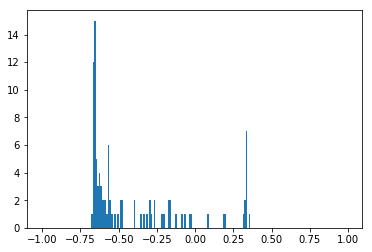

In [0]:
lossf = nn.MSELoss(reduction='mean')
# asp = []
# ap = []
# asu = []
out = []
tars = []

for i in range(100):
  inp = X_val[i,:]
  tar = y_val[i,:]
#   ind = np.random.randint(0,len(X_test)-1,1)
#   tein = X_test[ind,:]
#   tetar = y_test[ind,:]
  if USE_GPU == True:
      inp = inp.cuda()
      tar = tar.cuda()
#   start = time.time()
  ou = best_model(inp)
  
  loss = lossf(ou,tar.float())
#   print(loss)
#   if loss > 1:
#     print(i)
#   end = time.time()
#   mtime = end - start
#   print('each modeling time is',mtime)
#   if USE_GPU == True: #each modeling time is 0.0008425712585449219
#       out = out.cpu()
#       inp = inp.cpu()
#   out = out.detach().numpy()
  ou = ou.cpu()
  tar = tar.cpu()
  ou = ou.detach().numpy()
  tar = tar.detach().numpy()
  out.append(ou)
  tars.append(tar)

asp = [out[i][0] - tars[i][0] for i in range(len(out))]
ap = [out[i][1] - tars[i][1] for i in range(len(out))]
asu = [out[i][2] - tars[i][2] for i in range(len(out))]
plt.hist(asp,bins = np.arange(-1,1,0.01))

#Save the model parameters to a pickled file.


In [0]:
file_name = 'FC'
torch.save(model.state_dict(), file_name)

# file_name = 'models'
# with open(file_name, "wb") as f:
#     pk.dump(results, f)
#state_dict = torch.load('checkpoint.pth')
#model.load_state_dict(state_dict)

# file_name = 'models'
# with open(file_name, "rb") as f:
# # #     results = pk.load(f)
# VAL_LOSS = [VAL_LOSS[i].cpu() for i in range(len(VAL_LOSS))]
# VAL_LOSS = [VAL_LOSS[I].detach().numpy() for I in range(len(VAL_LOSS))]
# TRAIN_LOSS = [TRAIN_LOSS[i].cpu() for i in range(len(VAL_LOSS))]
# TRAIN_LOSS = [TRAIN_LOSS[I].detach().numpy() for I in range(len(TRAIN_LOSS))]

file_name = 'bestloss'
with open(file_name, "wb") as f:
    pk.dump([TRAIN_LOSS,VAL_LOSS], f)

In [0]:
TRAIN_LOSS[0]

array(2239.277, dtype=float32)

#Do not train if using the model
, start from here after data spliting, need to put FC model state dictionary into the current working space.

In [0]:

state_dict = torch.load('FC')
hidden1 = 20
hidden2 = 80
hidden3 = 40
inputsize = 11

model = nn.Sequential(
              nn.Linear(inputsize, hidden1),
              nn.ReLU(),
              nn.Linear(hidden1,hidden2),
              nn.ReLU(),
              nn.Linear(hidden2,hidden3),
              nn.ReLU(),
          #     nn.Linear(hidden3,hidden4),
          #     nn.ReLU(),
          #     nn.Linear(hidden4,hidden3),
          #     nn.ReLU(),
              nn.Linear(hidden3,hidden2),
              nn.ReLU(),
              nn.Linear(hidden2,hidden1),
              nn.ReLU(),
              nn.Linear(hidden1,3),
              nn.Softmax()
          ).cuda()
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
check_accuracy(test_loader, model)

validation or test loss is tensor(0.1114, device='cuda:0')


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(0.1114, device='cuda:0')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  4.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  1.,  2.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  1.,
         0.,  0.,  1.,  0.,  2.,  6.,  2.,  2.,  0.,  3.,  3.,  2.,  5.,
         3.,  9., 17.,  6.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

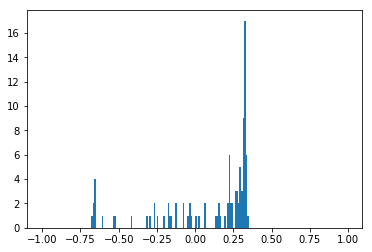

In [0]:
lossf = nn.MSELoss(reduction='mean')
# asp = []
# ap = []
# asu = []
out = []
tars = []

for i in range(100):
  inp = X_val[i,:]
  tar = y_val[i,:]
#   ind = np.random.randint(0,len(X_test)-1,1)
#   tein = X_test[ind,:]
#   tetar = y_test[ind,:]
  if USE_GPU == True:
      inp = inp.cuda()
      tar = tar.cuda()
#   start = time.time()
  ou = best_model(inp)
  
  loss = lossf(ou,tar.float())
#   print(loss)
#   if loss > 1:
#     print(i)
#   end = time.time()
#   mtime = end - start
#   print('each modeling time is',mtime)
#   if USE_GPU == True: #each modeling time is 0.0008425712585449219
#       out = out.cpu()
#       inp = inp.cpu()
#   out = out.detach().numpy()
  ou = ou.cpu()
  tar = tar.cpu()
  ou = ou.detach().numpy()
  tar = tar.detach().numpy()
  out.append(ou)
  tars.append(tar)

asp = [out[i][0] - tars[i][0] for i in range(len(out))]
ap = [out[i][1] - tars[i][1] for i in range(len(out))]
asu = [out[i][2] - tars[i][2] for i in range(len(out))]
plt.hist(ap,bins = np.arange(-1,1,0.01))